In [70]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.get_backend()
import seaborn as sns
import pickle, re
import numpy as np
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [71]:
data_train = pd.read_csv('EI-oc-En-fear-train.txt', sep='\t', error_bad_lines=False)
data_train.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]
data_dev = pd.read_csv('EI-oc-En-fear-dev.txt', sep='\t', error_bad_lines=False)
data_dev.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]
data_test= pd.read_csv("EI-oc-En-fear-test.txt", sep='\t', error_bad_lines=False)
data_test.columns = ["ID", "Tweet", "Affect_Dimension", "Intensity_Class"]

frames = [data_train,data_dev]
data_train = pd.concat(frames)

data_train['Intensity_Class'] = pd.Categorical(data_train['Intensity_Class'])
data_train['Intensity_Class'] = data_train.Intensity_Class.cat.codes

data_test['Intensity_Class'] = pd.Categorical(data_test['Intensity_Class'])
data_test['Intensity_Class'] = data_test.Intensity_Class.cat.codes

<ipython-input-71-f7210cecfae6>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_train = pd.read_csv('EI-oc-En-fear-train.txt', sep='\t', error_bad_lines=False)
<ipython-input-71-f7210cecfae6>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_dev = pd.read_csv('EI-oc-En-fear-dev.txt', sep='\t', error_bad_lines=False)
<ipython-input-71-f7210cecfae6>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_test= pd.read_csv("EI-oc-En-fear-test.txt", sep='\t', error_bad_lines=False)


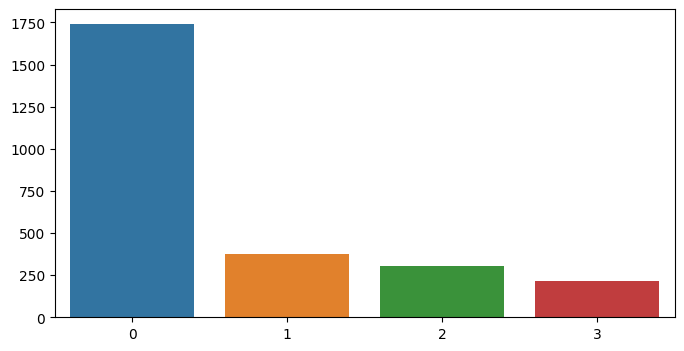

In [72]:
class_count = data_train['Intensity_Class'].value_counts()

x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(8,4))
sns.barplot(data = data_train, x=x,y=y)
plt.show()


In [73]:
stop_words = set(stopwords.words('english'))
stop_words.update(["now","let", 'zero', 'one', 'two', 'three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        #fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


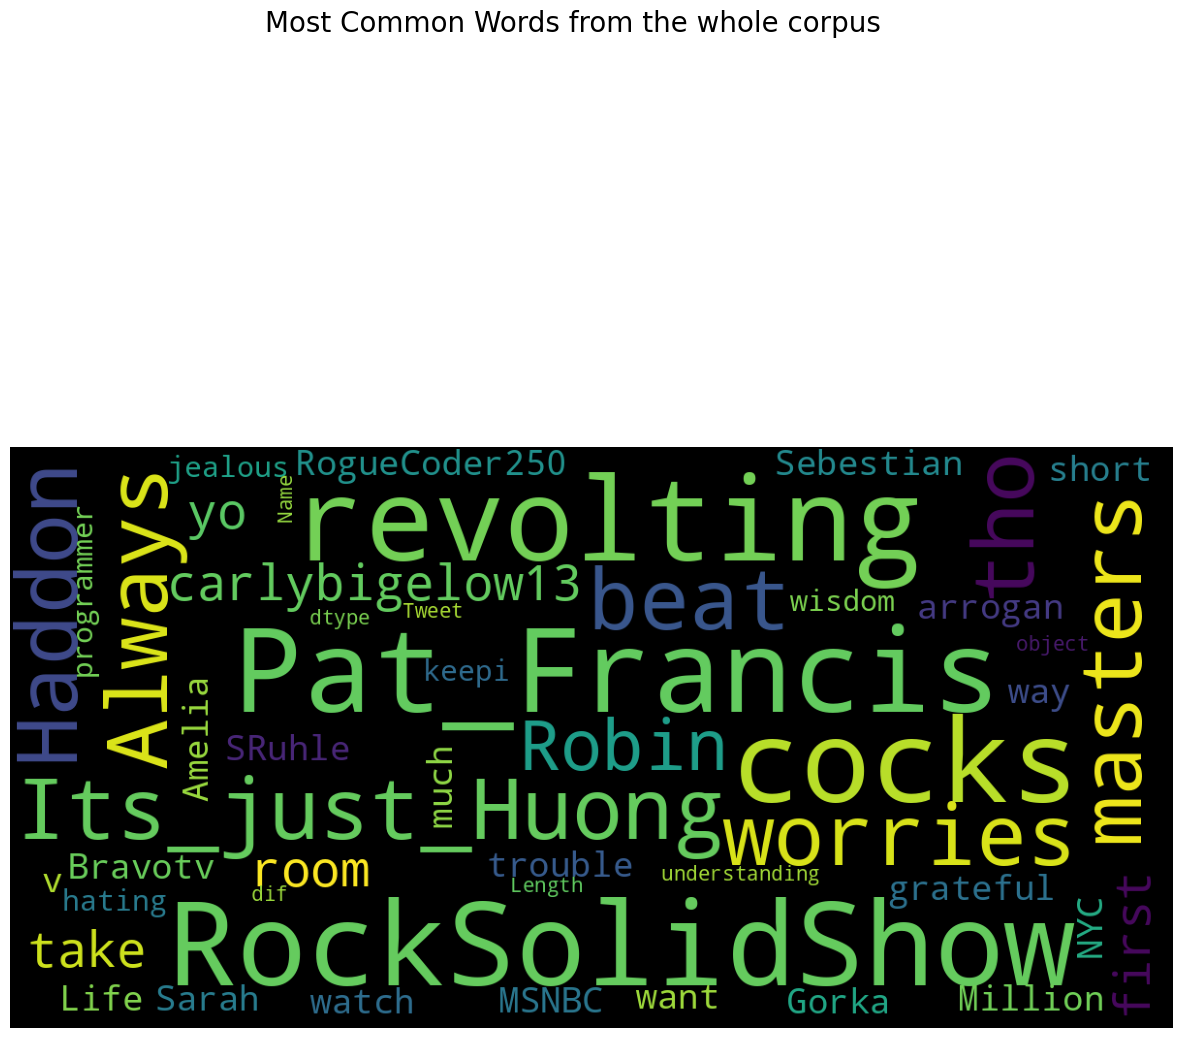

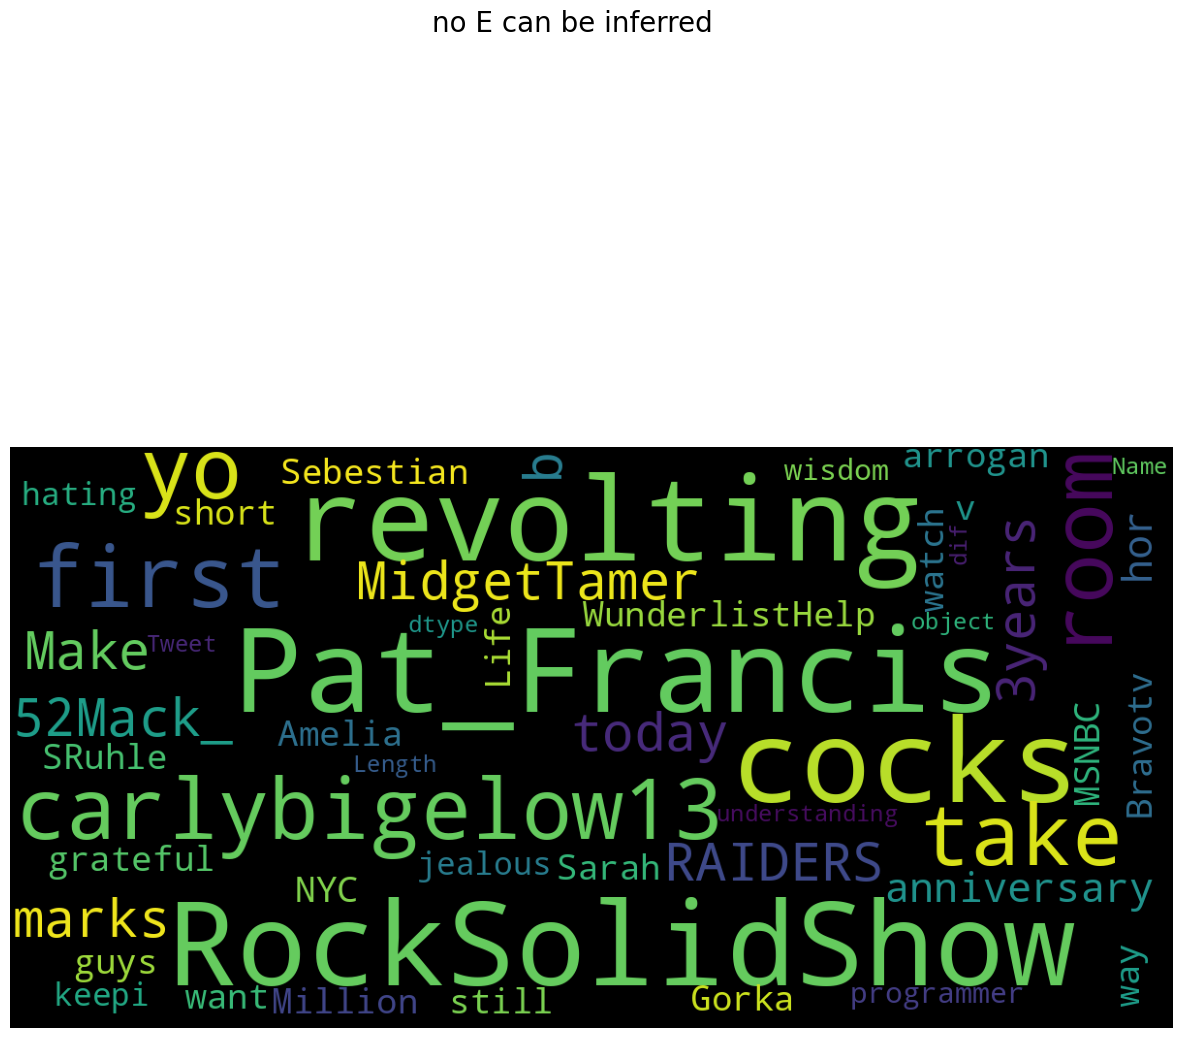

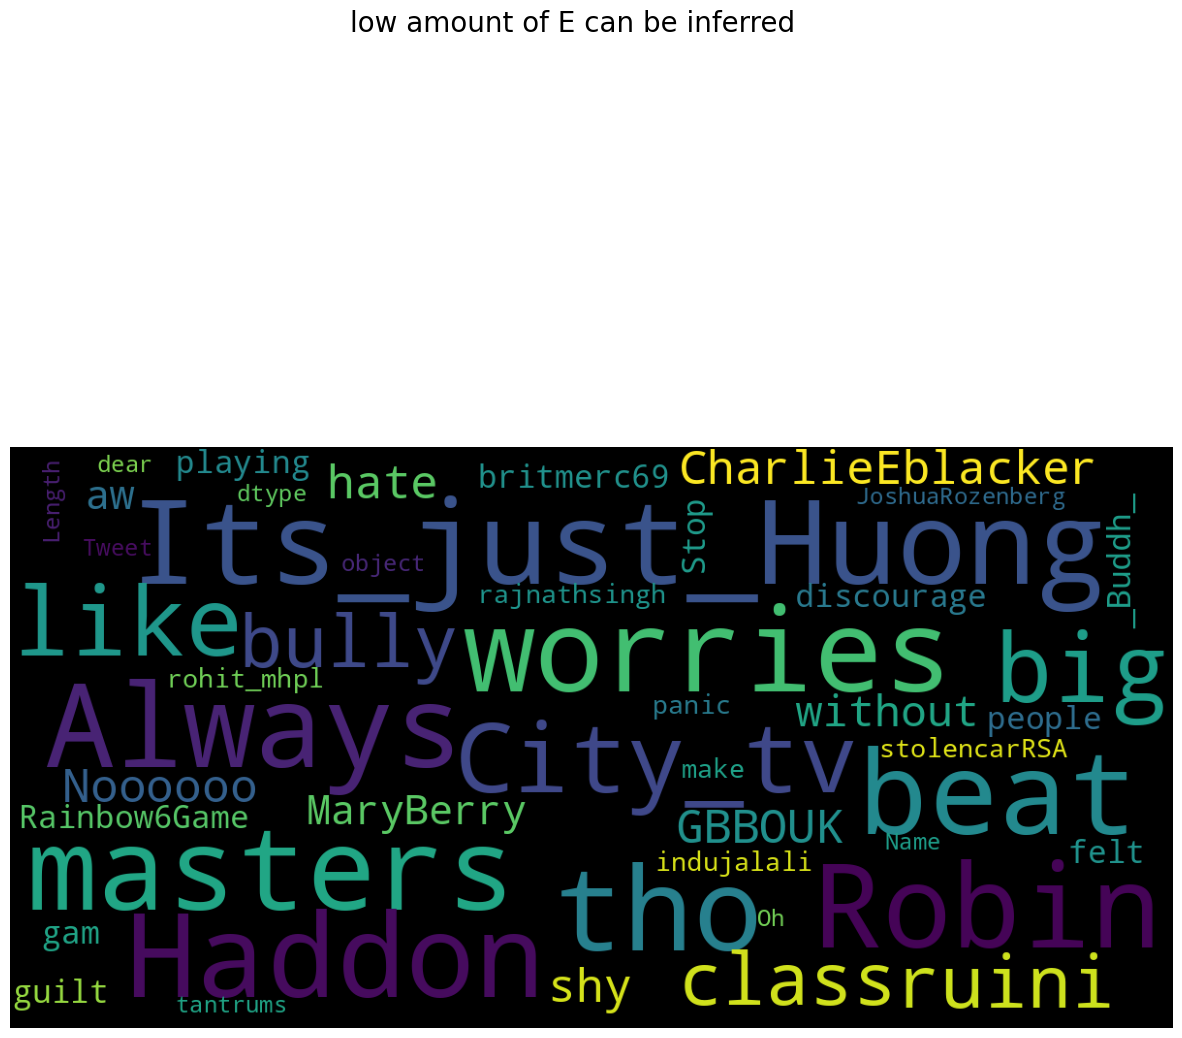

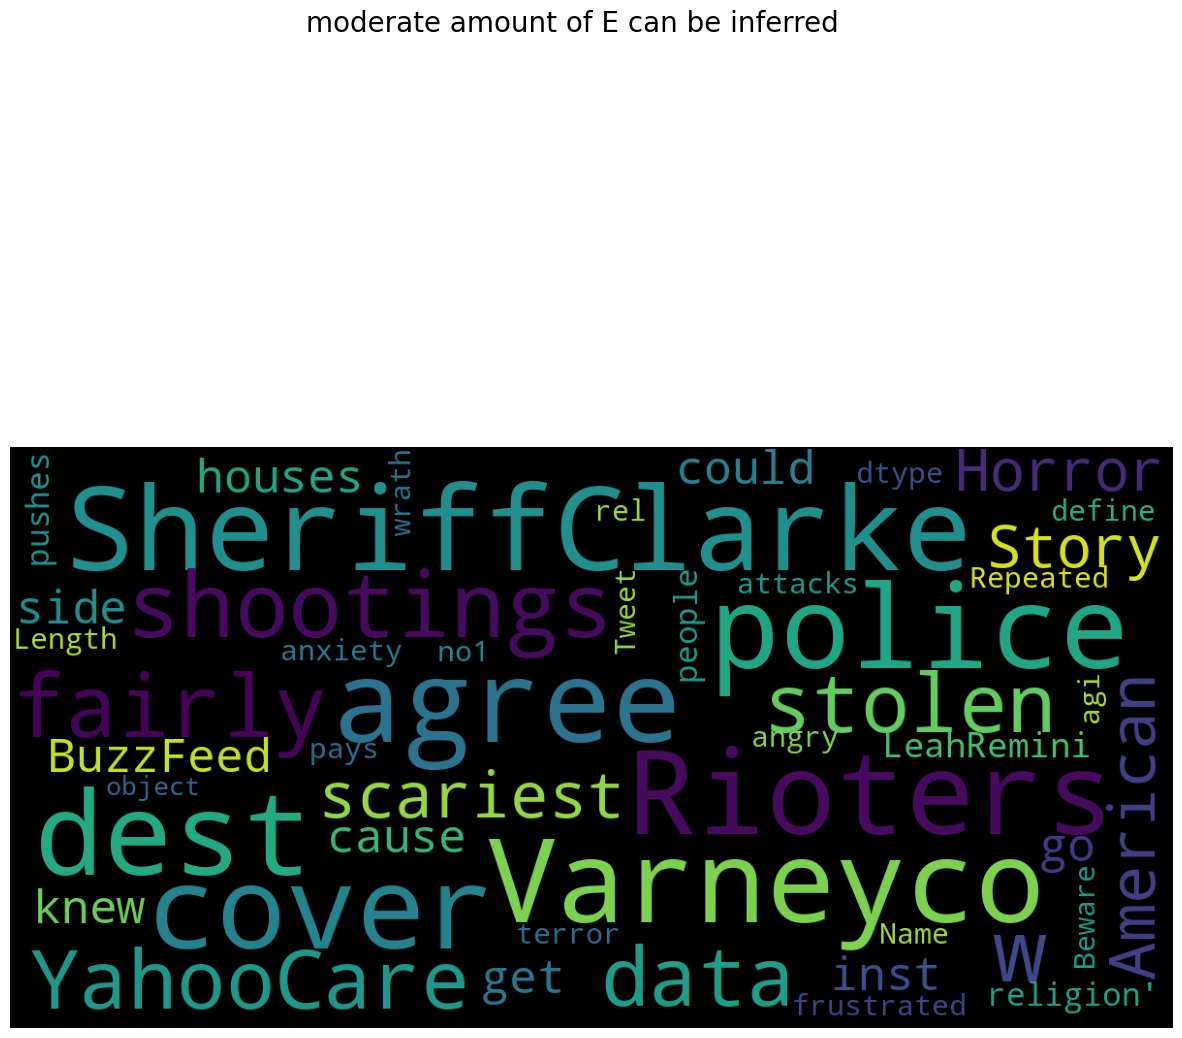

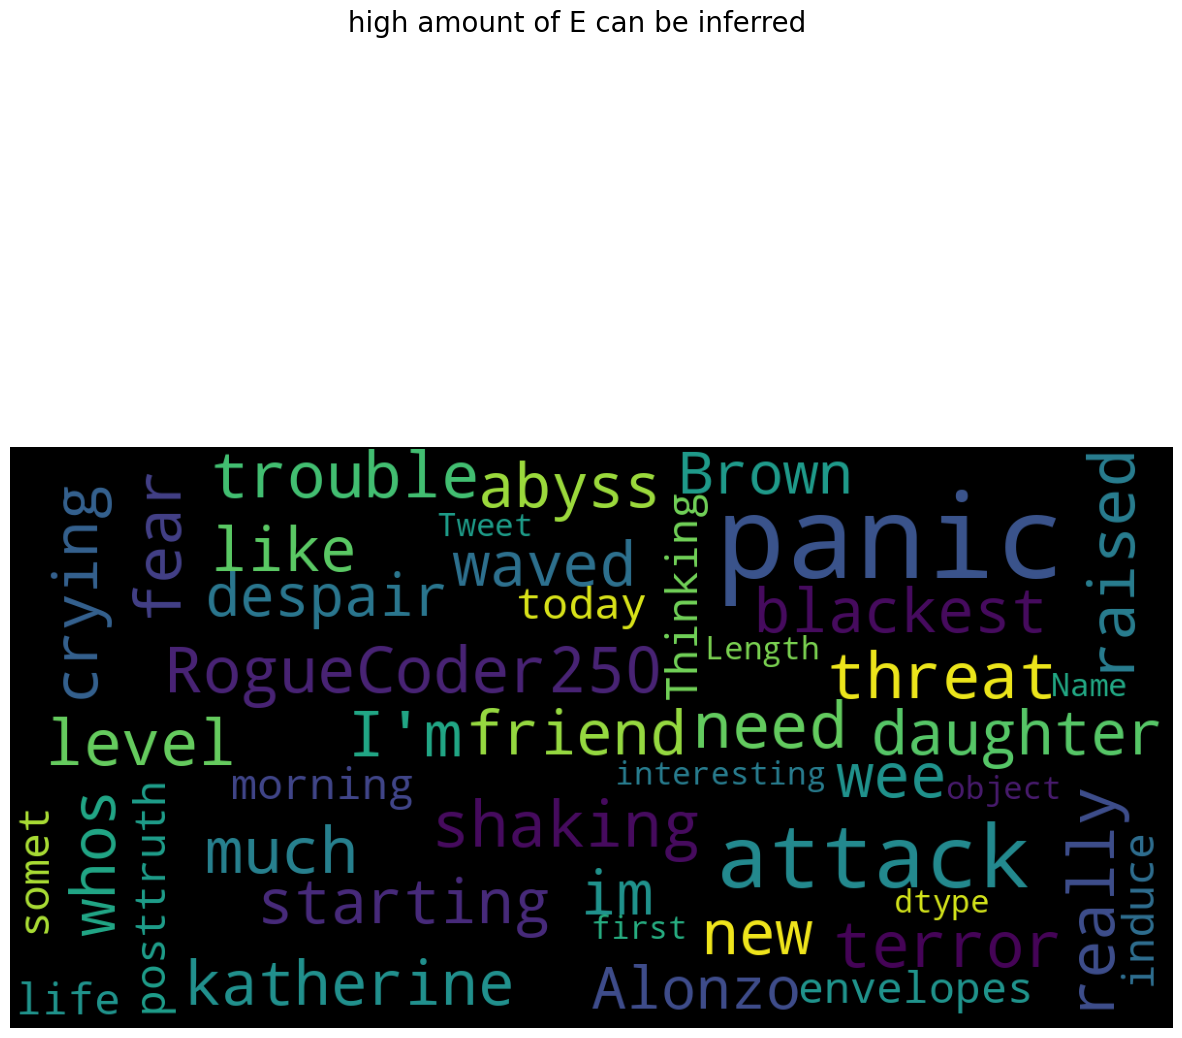

In [74]:
show_wordcloud(data_train['Tweet'],'Most Common Words from the whole corpus')
show_wordcloud(data_train[data_train['Intensity_Class'] == 0]['Tweet'],'no E can be inferred')
show_wordcloud(data_train[data_train['Intensity_Class'] == 1]['Tweet'],'low amount of E can be inferred')
show_wordcloud(data_train[data_train['Intensity_Class'] == 2]['Tweet'],'moderate amount of E can be inferred')
show_wordcloud(data_train[data_train['Intensity_Class'] == 3]['Tweet'],' high amount of E can be inferred')

In [75]:
#Removing Stop Words
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data_train['Tweet'] = data_train['Tweet'].apply(removeStopWords)
data_test['Tweet'] = data_test['Tweet'].apply(removeStopWords)

#Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [76]:
data_train['Tweet'] = data_train['Tweet'].apply(stemming)
data_test['Tweet'] = data_test['Tweet'].apply(stemming)

In [77]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer()

In [78]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), tokenizer=tokenizer.tokenize)
full_text = list(data_train['Tweet'].values) + list(data_test['Tweet'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(data_train['Tweet'])
test_vectorized = vectorizer.transform(data_test['Tweet'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [79]:
x_train = train_vectorized
y_train = data_train['Intensity_Class']
x_test = test_vectorized
y_test = data_test["Intensity_Class"]

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train,y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [81]:
print(classification_report(ovr.predict(x_test) , y_test))
print(accuracy_score( ovr.predict(x_test) , y_test ))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       981
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.99       986
   macro avg       0.33      0.33      0.33       986
weighted avg       0.99      0.99      0.99       986

0.9949290060851927


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
svm = LinearSVC()
svm.fit(x_train,y_train)
print(classification_report( svm.predict(x_test) , y_test))
print(accuracy_score( svm.predict(x_test) , y_test ))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       906
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        25

    accuracy                           0.92       986
   macro avg       0.23      0.25      0.24       986
weighted avg       0.84      0.92      0.88       986

0.9188640973630832


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
estimators = [ ('svm',svm) , ('ovr' , ovr) ]
clf = VotingClassifier(estimators , voting='hard')
clf.fit(x_train,y_train)

VotingClassifier(estimators=[('svm', LinearSVC()),
                             ('ovr',
                              OneVsRestClassifier(estimator=LogisticRegression()))])

In [84]:
print(classification_report( clf.predict(x_test) , y_test))
print(accuracy_score( clf.predict(x_test) , y_test ))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       981
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.99       986
   macro avg       0.33      0.33      0.33       986
weighted avg       0.99      0.99      0.99       986

0.9949290060851927


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
